# WESAD Data: Feature Selection, Balancing, and Classification

## 1. Imports

In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif # Example: Filter method (ANOVA F-value)
from sklearn.feature_selection import RFE # Example: Wrapper method
from sklearn.ensemble import RandomForestClassifier # Often used for feature importance & RFE
from imblearn.over_sampling import SMOTE # Example: Oversampling technique
# Or use class weights if preferred and supported by the model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Optional: for more advanced balancing or selection methods
# from imblearn.pipeline import Pipeline as ImbPipeline # To combine sampler with model
# from sklearn.pipeline import Pipeline # Standard sklearn pipeline

# Configure plots
# %matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('darkgrid')

## 2. Load and Clean Data

In [14]:
# --- Step 2.1: Load data from pickle file ---
import pickle
import numpy as np
import pandas as pd
import os # Import os for path joining if needed

# Assign path (adjust if necessary for your current environment)
# Using os.path.join is generally safer for cross-platform compatibility
# data_set_base = os.path.join('C:', os.sep, 'Users', 'ferri', 'Downloads', 'PoliTO', 'Tesi', 'DSs', 'Emotion-Stress', 'WESAD') # More robust path construction
data_set_base = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\WESAD\\' # Original path
s2_path = os.path.join(data_set_base, 'S2', 'S2.pkl')

print(f"Attempting to load data from: {s2_path}")

try:
    with open(s2_path, 'rb') as file:
        s2_data = pickle.load(file, encoding='latin1')
    print("S2.pkl loaded successfully.")

    # --- Step 2.2: Extract relevant signals (Chest sensors + Label) ---
    c_ax = s2_data['signal']['chest']['ACC'][:, 0]
    c_ay = s2_data['signal']['chest']['ACC'][:, 1]
    c_az = s2_data['signal']['chest']['ACC'][:, 2]
    c_ecg = s2_data['signal']['chest']['ECG'][:, 0]
    c_emg = s2_data['signal']['chest']['EMG'][:, 0]
    c_eda = s2_data['signal']['chest']['EDA'][:, 0]
    c_temp = s2_data['signal']['chest']['Temp'][:, 0]
    c_resp = s2_data['signal']['chest']['Resp'][:, 0]
    # Label is sampled at 700 Hz like chest sensors
    label = s2_data['label']

    print("Signals extracted.")
    print(f"  Length of c_ax: {len(c_ax)}")
    print(f"  Length of label: {len(label)}") # Should match chest sensor length

    # --- Step 2.3: Create initial DataFrame ---
    # Combine arrays - ensure they have the same length
    # Note: Using the label directly as it matches the chest sensor frequency (700Hz)
    if len(c_ax) == len(label):
         numpy_data = np.array([
             c_ax, c_ay, c_az, c_ecg, c_emg, c_eda, c_temp, c_resp, label
         ])
         numpy_data = numpy_data.T # Transpose to get samples as rows, features as columns

         feature_columns = ["c_ax", "c_ay", "c_az", "c_ecg", "c_emg", "c_eda", "c_temp", "c_resp"]
         df_initial = pd.DataFrame(
             data=numpy_data,
             columns=feature_columns + ["w_label"] # Use 'w_label' to match later code
            )
         print(f"Initial DataFrame created. Shape: {df_initial.shape}")
    else:
         print(f"Error: Length mismatch between chest sensors ({len(c_ax)}) and labels ({len(label)}). Cannot create DataFrame.")
         df_initial = pd.DataFrame() # Create empty df to handle error downstream


    # --- Step 2.4: Remove Outliers using IQR ---
    if not df_initial.empty:
        print("Calculating IQR and removing outliers...")
        # Exclude the label column from outlier calculation
        features_for_iqr = df_initial[feature_columns]

        Q1 = features_for_iqr.quantile(0.25)
        Q3 = features_for_iqr.quantile(0.75)
        IQR = Q3 - Q1

        # Create a boolean mask for rows that are *not* outliers in any feature column
        # Apply condition only to feature columns, then use the index to filter df_initial
        is_not_outlier = ~((features_for_iqr < (Q1 - 1.5 * IQR)) | (features_for_iqr > (Q3 + 1.5 * IQR))).any(axis=1)

        # Filter the original dataframe (including the label) using the mask
        df_cleaned = df_initial[is_not_outlier].copy() # Use .copy() to avoid SettingWithCopyWarning

        print(f"Outlier removal complete.")
        print(f"Shape before outlier removal: {df_initial.shape}")
        print(f"Shape after outlier removal: {df_cleaned.shape}")
        print(f"Number of rows removed: {df_initial.shape[0] - df_cleaned.shape[0]}")

        # Optional: Check label distribution after cleaning
        print("\nClass distribution after cleaning:")
        print(df_cleaned['w_label'].value_counts())

        # Display info and head of the cleaned data
        print("\nCleaned DataFrame Info:")
        df_cleaned.info()
        print("\nCleaned DataFrame Head:")
        display(df_cleaned.head())

    else:
         # If df_initial was empty due to length mismatch or other error
         df_cleaned = pd.DataFrame()
         print("\nSkipping outlier removal as initial DataFrame is empty.")


except FileNotFoundError:
    print(f"Error: S2.pkl not found at path '{s2_path}'.")
    print("Please ensure the WESAD dataset is correctly placed and the path is correct.")
    df_cleaned = pd.DataFrame() # Ensure df_cleaned exists but is empty

except KeyError as e:
    print(f"Error: Missing key in the pickle file structure: {e}")
    print("The structure of S2.pkl might be different than expected.")
    df_cleaned = pd.DataFrame()

except Exception as e:
    print(f"An unexpected error occurred during data loading or initial processing: {e}")
    df_cleaned = pd.DataFrame()

# Final check before proceeding
if df_cleaned.empty:
    print("\nStopping execution as cleaned data could not be generated.")
    # Optional: Halt execution if needed
    # raise SystemExit("Cleaned data needed to proceed.")

Attempting to load data from: C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\WESAD\S2\S2.pkl
S2.pkl loaded successfully.
Signals extracted.
  Length of c_ax: 4255300
  Length of label: 4255300
Initial DataFrame created. Shape: (4255300, 9)
Calculating IQR and removing outliers...
Outlier removal complete.
Shape before outlier removal: (4255300, 9)
Shape after outlier removal: (2182135, 9)
Number of rows removed: 2073165

Class distribution after cleaning:
w_label
0.0    1230433
2.0     316935
4.0     260238
3.0     239191
1.0      53659
7.0      41743
6.0      39936
Name: count, dtype: int64

Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2182135 entries, 393691 to 4255299
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   c_ax     float64
 1   c_ay     float64
 2   c_az     float64
 3   c_ecg    float64
 4   c_emg    float64
 5   c_eda    float64
 6   c_temp   float64
 7   c_resp   float64
 8   w_label  float64
dtypes: float

,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp,w_label
393691,0.6430,-0.0600,-0.6966,-0.044998,-0.008011,2.652359,28.717804,-0.965881,1.0
394476,0.6408,-0.0638,-0.6892,-0.176926,-0.014557,2.648163,28.716339,1.914978,1.0
395154,0.6394,-0.0602,-0.6918,0.052231,0.009659,2.662659,28.719208,-1.673889,1.0
396635,0.6354,-0.0684,-0.6998,-0.138611,0.000000,2.662277,28.716339,2.491760,1.0
402178,0.6392,-0.0626,-0.6972,0.045822,-0.006775,2.648163,28.820953,2.105713,1.0


## 3. Data Preparation for Machine Learning

In [15]:
if not df_cleaned.empty:
    # Define features (all columns except the label)
    X = df_cleaned.drop('w_label', axis=1)
    # Define target variable
    y = df_cleaned['w_label']

    # Get feature names for later use
    feature_names = X.columns.tolist()

    print("Features (X) shape:", X.shape)
    print("Target (y) shape:", y.shape)
    print("\nFeature Names:", feature_names)
    print("\nTarget Variable unique values:", y.unique())
    print("\nTarget Variable distribution:\n", y.value_counts(normalize=True) * 100)

    # Split data into Training (80%) and Testing (20%) sets
    # Use stratify=y to ensure the class distribution is similar in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\n--- Splitting Results ---")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train distribution:\n", y_train.value_counts(normalize=True) * 100)
    print("y_test distribution:\n", y_test.value_counts(normalize=True) * 100)
else:
    print("Cannot proceed without loaded data.")

Features (X) shape: (2182135, 8)
Target (y) shape: (2182135,)

Feature Names: ['c_ax', 'c_ay', 'c_az', 'c_ecg', 'c_emg', 'c_eda', 'c_temp', 'c_resp']

Target Variable unique values: [1. 0. 2. 6. 4. 3. 7.]

Target Variable distribution:
 w_label
0.0    56.386658
2.0    14.524078
4.0    11.925843
3.0    10.961329
1.0     2.459014
7.0     1.912943
6.0     1.830134
Name: proportion, dtype: float64

--- Splitting Results ---
X_train shape: (1745708, 8)
X_test shape: (436427, 8)
y_train distribution:
 w_label
0.0    56.386692
2.0    14.524078
4.0    11.925820
3.0    10.961341
1.0     2.459002
7.0     1.912920
6.0     1.830146
Name: proportion, dtype: float64
y_test distribution:
 w_label
0.0    56.386521
2.0    14.524078
4.0    11.925935
3.0    10.961283
1.0     2.459060
7.0     1.913035
6.0     1.830088
Name: proportion, dtype: float64


## 4. Feature Scaling

In [16]:
if not df_cleaned.empty:
    scaler = StandardScaler()

    # Fit on training data
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform test data using the same scaler
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for easier handling (optional, but good practice)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

    print("--- Scaling Applied ---")
    print("Scaled Training Data Head:")
    display(X_train_scaled.head())
    print("\nScaled Training Data Description:")
    display(X_train_scaled.describe())
else:
    print("Cannot proceed without loaded data.")

--- Scaling Applied ---
Scaled Training Data Head:


,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp
3373811,0.712762,-0.831453,0.865360,0.690264,-0.432052,-0.634529,0.796789,-0.608840
2321482,-0.734452,-0.027938,-1.038666,0.332780,1.748389,0.486586,0.474083,-0.107861
2208175,0.655234,2.096137,0.566658,0.079331,0.825696,1.384882,-0.866377,-2.370302
1486374,0.527591,0.405261,0.181700,0.064390,0.547342,0.133058,-1.360256,-1.115177
2231604,0.461073,1.865564,0.505960,0.336100,-0.921749,0.898013,-0.657535,-1.892765



Scaled Training Data Description:


,c_ax,c_ay,c_az,c_ecg,c_emg,c_eda,c_temp,c_resp
count,1.745708e+06,1.745708e+06,1.745708e+06,1.745708e+06,1.745708e+06,1.745708e+06,1.745708e+06,1.745708e+06
mean,-3.705066e-16,-1.583318e-18,-7.796926e-17,1.538749e-17,5.294093e-17,8.933741e-17,-4.826862e-16,9.390013e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.608672e+00,-3.780006e+00,-2.517002e+00,-2.641642e+00,-2.792908e+00,-1.873194e+00,-4.805389e+00,-2.674372e+00
25%,-2.432824e-02,-6.567761e-01,-4.700138e-01,-5.714447e-01,-6.382405e-01,-7.248847e-01,-6.291496e-01,-7.160012e-01
50%,4.143304e-01,-1.047958e-01,1.090212e-01,2.453454e-01,6.279962e-02,-2.484561e-02,-1.535683e-01,-1.085312e-01
75%,6.156822e-01,5.450033e-01,5.778397e-01,6.028294e-01,6.607456e-01,3.874581e-01,7.186615e-01,7.313448e-01
max,4.171694e+00,3.766052e+00,3.357207e+00,2.790344e+00,2.748402e+00,3.619218e+00,3.915353e+00,2.769417e+00


## 5. Feature Selection

In [17]:
if not df_cleaned.empty:
    # Select the top k features (e.g., k=5)
    k_best = 5
    selector_kbest = SelectKBest(score_func=f_classif, k=k_best)

    # Fit on the *scaled* training data
    selector_kbest.fit(X_train_scaled, y_train)

    # Get the selected feature names
    selected_features_mask_kbest = selector_kbest.get_support()
    selected_features_kbest = X_train_scaled.columns[selected_features_mask_kbest]

    print(f"--- SelectKBest (k={k_best}) ---")
    print("Selected Features:", selected_features_kbest.tolist())

    # Transform both train and test sets to keep only selected features
    X_train_kbest = selector_kbest.transform(X_train_scaled)
    X_test_kbest = selector_kbest.transform(X_test_scaled)

    # Convert back to DataFrame (optional)
    X_train_kbest = pd.DataFrame(X_train_kbest, columns=selected_features_kbest, index=X_train.index)
    X_test_kbest = pd.DataFrame(X_test_kbest, columns=selected_features_kbest, index=X_test.index)

    print("Shape after KBest selection (Train):", X_train_kbest.shape)
    print("Shape after KBest selection (Test):", X_test_kbest.shape)
else:
    print("Cannot proceed without loaded data.")

--- SelectKBest (k=5) ---
Selected Features: ['c_ax', 'c_ay', 'c_az', 'c_eda', 'c_temp']
Shape after KBest selection (Train): (1745708, 5)
Shape after KBest selection (Test): (436427, 5)


**Example 2: Wrapper Method (Recursive Feature Elimination - RFE)**

In [19]:
if not df_cleaned.empty:
    # Define the model to use for RFE
    rfe_estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1) # Use a simple RF

    # Select the desired number of features (e.g., n_features_to_select=4)
    n_features_rfe = 4
    selector_rfe = RFE(estimator=rfe_estimator, n_features_to_select=n_features_rfe, step=1) # Remove 1 feature per step

    # Fit RFE on the *scaled* training data
    print(f"\n--- RFE (n_features={n_features_rfe}) ---")
    print("Fitting RFE... (this might take a moment)")
    selector_rfe.fit(X_train_scaled, y_train)
    print("RFE fitting complete.")

    # Get the selected feature names
    selected_features_mask_rfe = selector_rfe.support_
    selected_features_rfe = X_train_scaled.columns[selected_features_mask_rfe]

    print("Selected Features:", selected_features_rfe.tolist())
    print("Feature Ranking:", selector_rfe.ranking_) # Lower rank is better (1 means selected)

    # Transform both train and test sets
    X_train_rfe = selector_rfe.transform(X_train_scaled)
    X_test_rfe = selector_rfe.transform(X_test_scaled)

    # Convert back to DataFrame (optional)
    X_train_rfe = pd.DataFrame(X_train_rfe, columns=selected_features_rfe, index=X_train.index)
    X_test_rfe = pd.DataFrame(X_test_rfe, columns=selected_features_rfe, index=X_test.index)

    print("Shape after RFE selection (Train):", X_train_rfe.shape)
    print("Shape after RFE selection (Test):", X_test_rfe.shape)
else:
    print("Cannot proceed without loaded data.")


--- RFE (n_features=4) ---
Fitting RFE... (this might take a moment)
RFE fitting complete.
Selected Features: ['c_ax', 'c_az', 'c_eda', 'c_temp']
Feature Ranking: [1 2 1 4 5 1 1 3]
Shape after RFE selection (Train): (1745708, 4)
Shape after RFE selection (Test): (436427, 4)


**Choose which set of selected features to proceed with:**

In [20]:
# Assign chosen features for the next steps
X_train_selected = X_train_rfe
X_test_selected = X_test_rfe
selected_feature_names = selected_features_rfe.tolist()

print(f"\nProceeding with features selected by RFE: {selected_feature_names}")



Proceeding with features selected by RFE: ['c_ax', 'c_az', 'c_eda', 'c_temp']


## 6. Class Balancing (on Training Data)

In [21]:
if X_train_selected is not None and y_train is not None: # Check if RFE output is valid
    print("\n--- Class Balancing (SMOTE) ---")
    print("Class distribution before SMOTE:")
    print(y_train.value_counts())

    # Check if smallest class size allows k_neighbors=5
    min_class_count = y_train.value_counts().min()
    k_neighbors = min(5, max(1, min_class_count - 1)) # Adjust k if necessary
    print(f"Using k_neighbors={k_neighbors} for SMOTE.")

    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

    try:
        # Fit SMOTE *only* on the selected training data
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

        print("\nClass distribution after SMOTE:")
        print(y_train_balanced.value_counts())

        print("\nShape of balanced training data:", X_train_balanced.shape)
        print("Shape of balanced training labels:", y_train_balanced.shape)

    except ValueError as ve:
        print(f"\nError during SMOTE: {ve}")
        print("This might happen if a class has fewer samples than k_neighbors even after checks.")
        # Handle error: Maybe skip balancing or try a different method
        X_train_balanced, y_train_balanced = X_train_selected, y_train # Fallback?
    except Exception as e:
         print(f"\nAn unexpected error occurred during SMOTE: {e}")
         X_train_balanced, y_train_balanced = X_train_selected, y_train # Fallback?


else:
    print("\nSkipping SMOTE because feature selection (RFE) failed or produced no output.")
    # Assign original data if you want subsequent cells to run (careful!)
    # Or ensure subsequent cells also check if balanced data exists.
    X_train_balanced, y_train_balanced = None, None # Keep as None if SMOTE didn't run


--- Class Balancing (SMOTE) ---
Class distribution before SMOTE:
w_label
0.0    984347
2.0    253548
4.0    208190
3.0    191353
1.0     42927
7.0     33394
6.0     31949
Name: count, dtype: int64
Using k_neighbors=5 for SMOTE.

Class distribution after SMOTE:
w_label
3.0    984347
0.0    984347
6.0    984347
2.0    984347
7.0    984347
4.0    984347
1.0    984347
Name: count, dtype: int64

Shape of balanced training data: (6890429, 4)
Shape of balanced training labels: (6890429,)


## 7. Machine Learning Model Training and Evaluation


--- Training SGD Logistic Regression ---
Accuracy: 0.5604
F1 Score (Weighted): 0.5403
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.28      0.42    246086
         1.0       0.45      0.93      0.61     10732
         2.0       0.49      0.81      0.61     63387
         3.0       0.50      0.95      0.66     47838
         4.0       0.91      1.00      0.95     52048
         6.0       0.21      0.98      0.35      7987
         7.0       0.20      0.98      0.33      8349

    accuracy                           0.56    436427
   macro avg       0.51      0.85      0.56    436427
weighted avg       0.73      0.56      0.54    436427

Confusion Matrix:


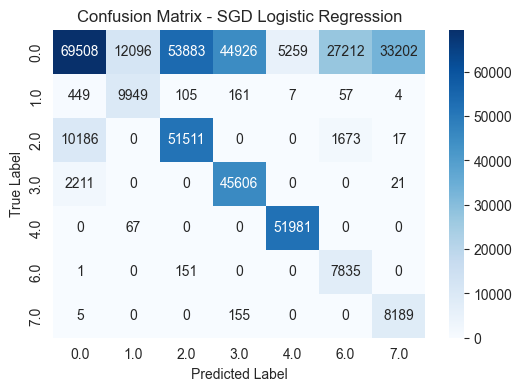


--- Training K-Nearest Neighbors ---
Accuracy: 0.9766
F1 Score (Weighted): 0.9769
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    246086
         1.0       1.00      1.00      1.00     10732
         2.0       0.97      1.00      0.98     63387
         3.0       0.97      0.99      0.98     47838
         4.0       0.96      0.99      0.98     52048
         6.0       0.93      0.99      0.96      7987
         7.0       0.75      0.98      0.85      8349

    accuracy                           0.98    436427
   macro avg       0.94      0.99      0.96    436427
weighted avg       0.98      0.98      0.98    436427

Confusion Matrix:


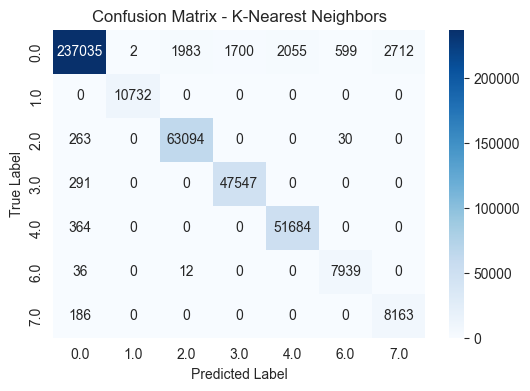


--- Training Decision Tree ---
Accuracy: 0.9743
F1 Score (Weighted): 0.9744
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98    246086
         1.0       1.00      1.00      1.00     10732
         2.0       0.97      0.98      0.98     63387
         3.0       0.98      0.98      0.98     47838
         4.0       0.97      0.98      0.98     52048
         6.0       0.94      0.96      0.95      7987
         7.0       0.80      0.85      0.82      8349

    accuracy                           0.97    436427
   macro avg       0.95      0.96      0.96    436427
weighted avg       0.97      0.97      0.97    436427

Confusion Matrix:


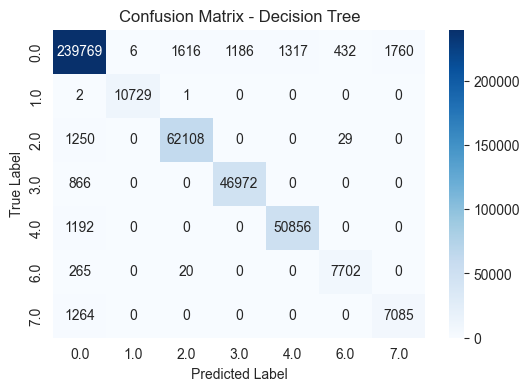


--- Training Random Forest ---
Accuracy: 0.9797
F1 Score (Weighted): 0.9800
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    246086
         1.0       1.00      1.00      1.00     10732
         2.0       0.97      0.99      0.98     63387
         3.0       0.98      0.99      0.98     47838
         4.0       0.97      0.99      0.98     52048
         6.0       0.94      0.99      0.97      7987
         7.0       0.79      0.95      0.86      8349

    accuracy                           0.98    436427
   macro avg       0.95      0.98      0.97    436427
weighted avg       0.98      0.98      0.98    436427

Confusion Matrix:


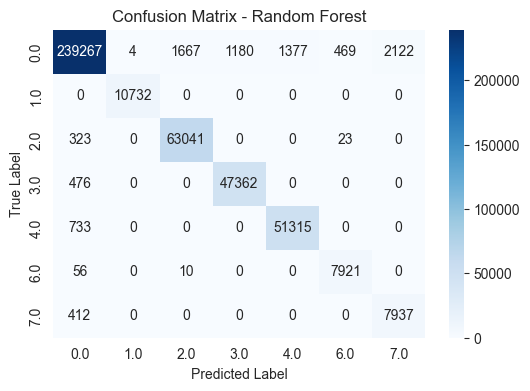


--- Training Gradient Boosting ---


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import SGDClassifier

if not df_cleaned.empty:
    # Define models to train
    models = {
        "SGD Logistic Regression": SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1), # Use log_loss for LR behavior
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    }

    results = {}

    # Loop through models, train, predict, and evaluate
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        # Train the model
        model.fit(X_train_balanced, y_train_balanced)

        # Make predictions on the test set
        y_pred = model.predict(X_test_selected)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted') # Use weighted F1 for imbalanced test set
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results[name] = {'accuracy': accuracy, 'f1_weighted': f1, 'report': report, 'confusion_matrix': cm}

        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (Weighted): {f1:.4f}")
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        # Visualize Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

else:
    print("Cannot proceed without loaded data.")

## 8. Results Summary


--- Model Performance Summary ---


,Model,Accuracy,F1 Score (Weighted)
3,Random Forest,0.979717,0.979956
1,K-Nearest Neighbors,0.976553,0.976938
2,Decision Tree,0.974323,0.974415
0,SGD Logistic Regression,0.560412,0.540306


C:\Users\ferri\AppData\Local\Temp\ipykernel_15184\1137936306.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score (Weighted)', y='Model', data=results_df, palette='viridis')


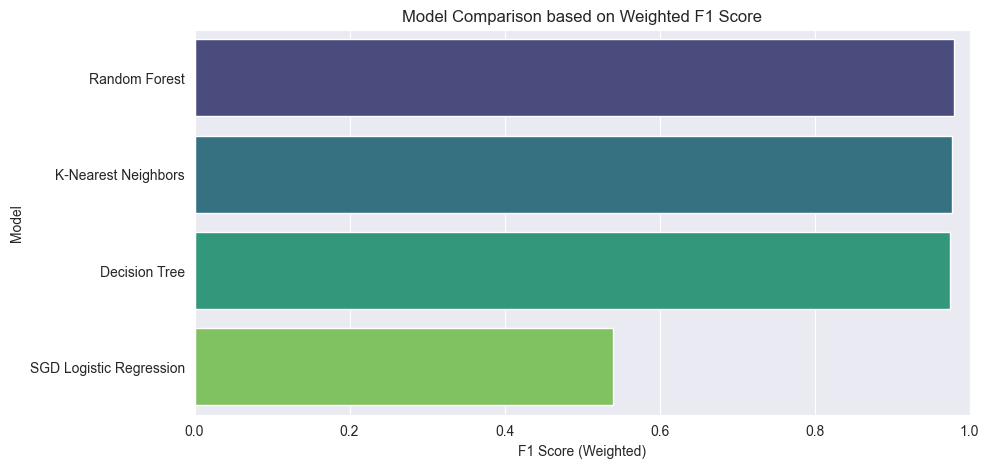

In [23]:
if not df_cleaned.empty and results:
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[m]['accuracy'] for m in results],
        'F1 Score (Weighted)': [results[m]['f1_weighted'] for m in results]
    })

    print("\n--- Model Performance Summary ---")
    results_df = results_df.sort_values(by='F1 Score (Weighted)', ascending=False)
    display(results_df)

    # Plot comparison
    plt.figure(figsize=(10, 5))
    sns.barplot(x='F1 Score (Weighted)', y='Model', data=results_df, palette='viridis')
    plt.title('Model Comparison based on Weighted F1 Score')
    plt.xlim(0, 1.0)
    plt.show()
else:
    print("No results to summarize.")